# Convolutional Neural Networks Introduction - MNIST Dataset

</begin><center>![alt text](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

</begin><center>![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

Notebook written by Gabriel R. Freitas, based on [this](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6) kaggle kernel and Clécio R. Bom classes on Introduction to Deep Learning in Astronomy.

## 1. Initial Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
from keras import backend as K

from tensorflow.python.client import device_lib
import tensorflow as tf

Using TensorFlow backend.


In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6130722809349950626
]


## 2. Splitting Data - train and test

In [3]:
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [4]:
# Load the data
train = pd.read_csv('mnist_data/train.csv')
test = pd.read_csv('mnist_data/test.csv')

In [5]:
y_train = train.loc[:,'label']
X_train = train.drop('label', axis=1) 
del train

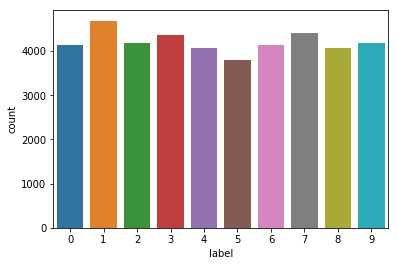

In [6]:
g = sns.countplot(y_train)

The set is well distributed.

In [7]:
# Reshape image in 3 dimensions (shape, canal=1, height=28px, width=28px)
X_train = X_train.values.reshape(X_train.shape[0], 1, 28, 28)
test = test.values.reshape(test.shape[0], 1, 28, 28)

In [8]:
# Normalize the data
X_train = X_train/255
test = test/255

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there are 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [9]:
# One Hot Encoding
num_classes = y_train.nunique()
y_train = np_utils.to_categorical(y_train, num_classes=num_classes)

In [10]:
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

## 3. Modeling the CNN

### 3.1 Defining Layers

In [11]:
# define the larger model
def cnn_layers():

    model = Sequential()

    # 1. Convolutional layer with 30 feature maps of size 5×5.
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))    
    # 2. Pooling layer taking the max over 2*2 patches.
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 3. Convolutional layer with 15 feature maps of size 3×3.
    model.add(Conv2D(15, (3, 3), activation='relu'))
    # 4. Pooling layer taking the max over 2*2 patches.
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 5. Dropout layer with a probability of 20%.
    model.add(Dropout(0.2))
    # 6. Flatten layer.
    model.add(Flatten())
    # 7. Fully connected layer with 128 neurons and rectifier activation.
    model.add(Dense(128, activation='relu'))
    # 8. Fully connected layer with 50 neurons and rectifier activation.
    model.add(Dense(50, activation='relu'))
    # 9. Output layer.
    model.add(Dense(num_classes, activation='softmax'))

    return model

### 3.2 Setting Model Parameters


In [12]:
# build the model
model = cnn_layers()

In [13]:
# defining optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [15]:
# setting a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## 4. Data Augmentation

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [17]:
epochs = 10
batch_size = 86

In [18]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data=(X_val, y_val),
                              verbose=1, 
                              steps_per_epoch=X_train.shape[0]//batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/10
439/439 [==============================] - 44s 100ms/step - loss: 0.6080 - acc: 0.8061 - val_loss: 0.1293 - val_acc: 0.9629
Epoch 2/10
439/439 [==============================] - 44s 101ms/step - loss: 0.2026 - acc: 0.9374 - val_loss: 0.0758 - val_acc: 0.9781
Epoch 3/10
439/439 [==============================] - 44s 100ms/step - loss: 0.1437 - acc: 0.9542 - val_loss: 0.0657 - val_acc: 0.9812
Epoch 4/10
439/439 [==============================] - 42s 96ms/step - loss: 0.1152 - acc: 0.9647 - val_loss: 0.0721 - val_acc: 0.9774
Epoch 5/10
439/439 [==============================] - 47s 107ms/step - loss: 0.1006 - acc: 0.9688 - val_loss: 0.0564 - val_acc: 0.9829
Epoch 6/10
439/439 [==============================] - 44s 100ms/step - loss: 0.0931 - acc: 0.9718 - val_loss: 0.0402 - val_acc: 0.9874
Epoch 7/10
439/439 [==============================] - 43s 99ms/step - loss: 0.0858 - acc: 0.9740 - val_loss: 0.0486 - val_acc: 0.9845
Epoch 8/10
439/439 [==============================] - 45s

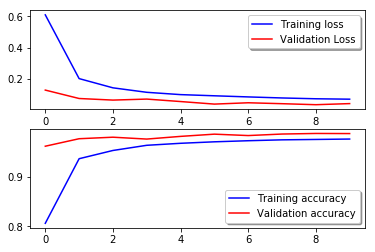

In [19]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
# Predict the values from the validation dataset
y_pred = model.predict(test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 

In [26]:
submission = pd.Series(y_pred_classes).reset_index()
submission.columns = ['ImageId', 'Label']
submission.ImageId += 1

In [23]:
submission.shape

(28000, 2)

In [28]:
submission.to_csv('mnist_submission.csv', index=False)

---